In [1]:
from src.model import PyTradeShifts
from src.utils import get_distance_matrix
from scipy.stats import linregress
from src.preprocessing import main as preprocessing_main
import os
import pandas as pd
import numpy as np

data_dir = os.path.join(os.path.dirname(os.getcwd()))
os.chdir(data_dir)

In [9]:
years_to_consider = list(range(2021, 2023))
#crops_to_consider = ["Maize (corn)", "Wheat", "Rice, paddy (rice milled equivalent)", "Soya beans"]
crops_to_consider = ["Rice, paddy (rice milled equivalent)"]


In [11]:
run_preprocessing = True
if run_preprocessing:
    for year in years_to_consider:
        print(year)
        for crop in crops_to_consider:
            preprocessing_main(region="All_Data", item=crop, year="Y" + str(year))

2021
Reading in data for Rice, paddy (rice milled equivalent) in All_Data...
Started to format production data


Filter production vector
Finished filtering production vector
Finished formatting production data

Started to format trade data
Filter trade matrix
Finished filtering trade matrix
Pivot trade matrix
Finished pivoting trade matrix
Finished formatting trade data

Unify indices
Finished unifying indices
Replacing country codes with country names in Trade data
Replacing country codes with country names in Production data
2022
Reading in data for Rice, paddy (rice milled equivalent) in All_Data...
Started to format production data
Filter production vector


KeyError: 'Y2022'

In [4]:
def get_matrices(crop, year):
    """Get trade and distance matrices for the global wheat trade in 2018."""
    crop_trade = PyTradeShifts(
        crop,
        year,
        region="Global",
        testing=True,
        make_plot=False,
    )
    
    crop_trade.load_data()
    crop_trade.remove_net_zero_countries()
    crop_trade.prebalance()
    crop_trade.correct_reexports()
    np.fill_diagonal(crop_trade.trade_matrix.values, 0)

    dm = get_distance_matrix(
        crop_trade.trade_matrix.index, crop_trade.trade_matrix.columns
    )
    return crop_trade.trade_matrix, dm

In [5]:
def get_xy_from_matrices(tm, dm):
    """Get x and y values from trade and distance matrices."""
    # a little melting trick, this will produce:
    # a df with three columns: country A, country B, volume of trade from A to B
    tm = tm.stack().reset_index()
    # a df with three columns: country A, country B, distance from A to B
    dm = dm.stack().reset_index()
    # index order should match because tm and dm should have the same index/columns
    # so we can just take the values and roll with it
    # otherwise we should do a formal join here
    y = tm[0].values
    x = dm[0].values
    # filter out zeroes
    x = x[y != 0]
    y = y[y != 0]
    # sort values by distance
    y = y[x.argsort()]
    x = x[x.argsort()]
    return x, y

We use the approach from [Karpiarz et al.](https://arxiv.org/pdf/1409.5963.pdf) (Fig. 1), since it is beyond the scope of our work to assess and validate the (well-established) gravity model.

We do not trouble ourselves with questioning whether it is or isn't a "proper" power-law etc., we only focus on obtaining comparible quantities to the work present in the above paper.

For a more advanced approach to power-law fitting see [Clauset et al.](https://arxiv.org/pdf/0706.1062.pdf)


In [6]:
def get_vr(x, y):
    # integrate over distance
    vr = np.cumsum(y)[::-1]
    return vr

In [7]:
def get_best_fit(x, vr):
    # convert to log-log
    x = np.log(x)
    vr = np.log(vr)
    # find the best fit in a reasonable range
    # in theory we could run this for each possible segment (computationally insane)
    # but a) we want to start from index 0 (we're interested in highest trade volume the most)
    # and b) we need to make sure we do not take too few points, becasue we risk overfitting
    best_r = 0
    best_a = 0
    best_b = 0
    best_end_of_lin = 0
    for end_of_lin in np.arange(100, 4001, 1):
        slope, intercept, r, p, stderr = linregress(x[0:end_of_lin], vr[0:end_of_lin])
        if r**2 > best_r:
            best_r = r**2
            best_a = slope
            best_b = intercept
            best_end_of_lin = end_of_lin

    # print the result, we print a+1 because the slope fitted to the integral
    # is a - 1 where a is the coefficient in the trade data
    return best_end_of_lin, best_r, best_a+1


In [8]:
# Create a dataframe with the years as the index and the crops as the columns
results = {}
for year in years_to_consider:
    results[year] = {}
    for crop in crops_to_consider:
        if crop == "Maize (corn)": crop = "Maize"
        if crop == "Rice, paddy (rice milled equivalent)": crop = "Rice"
        tm, dm = get_matrices(crop, year)
        x, y = get_xy_from_matrices(tm, dm)
        vr = get_vr(x, y)
        best_end_of_lin, best_r, best_a = get_best_fit(x, vr)
        results[year][crop] = best_a

# make the dataframe
df = pd.DataFrame(results).transpose()
# Save the dataframe
df.to_csv("results" +os.sep + "gravity_exponent.csv")

The duplicates are the following: 
Index(['Micronesia, Fed. Sts.', 'Micronesia, Fed. Sts.'], dtype='object')
The duplicates are the following: 
Index(['Micronesia, Fed. Sts.', 'Micronesia, Fed. Sts.'], dtype='object')
Loaded data for Maize in Y1993.
Removed 0 countries with no trade or production.
Prebalanced trade matrix.
Corrected re-exports.


Loaded data for Wheat in Y1993.
Removed 1 countries with no trade or production.
Prebalanced trade matrix.
Corrected re-exports.
Loaded data for Rice in Y1993.
Removed 1 countries with no trade or production.
Prebalanced trade matrix.
Corrected re-exports.
Loaded data for Soya beans in Y1993.
Removed 8 countries with no trade or production.
Prebalanced trade matrix.
Determinant=0 encountered in PyTradeShifts.correct_reexports().
Re-applying PyTradeShifts.remove_net_zero_countries().
Removed 1 countries with no trade or production.
Attempting to invert the matrix again.
Corrected re-exports.
The duplicates are the following: 
Index(['Micronesia, Fed. Sts.', 'Micronesia, Fed. Sts.'], dtype='object')
The duplicates are the following: 
Index(['Micronesia, Fed. Sts.', 'Micronesia, Fed. Sts.'], dtype='object')
Loaded data for Maize in Y1994.
Removed 1 countries with no trade or production.
Prebalanced trade matrix.
Corrected re-exports.
Loaded data for Wheat in Y1994.
Removed 0 countries wi

In [12]:
df = pd.read_csv("results" +os.sep + "gravity_exponent.csv", index_col=0)

array([[<Axes: title={'center': 'Maize'}>,
        <Axes: title={'center': 'Wheat'}>],
       [<Axes: title={'center': 'Rice'}>,
        <Axes: title={'center': 'Soya beans'}>]], dtype=object)

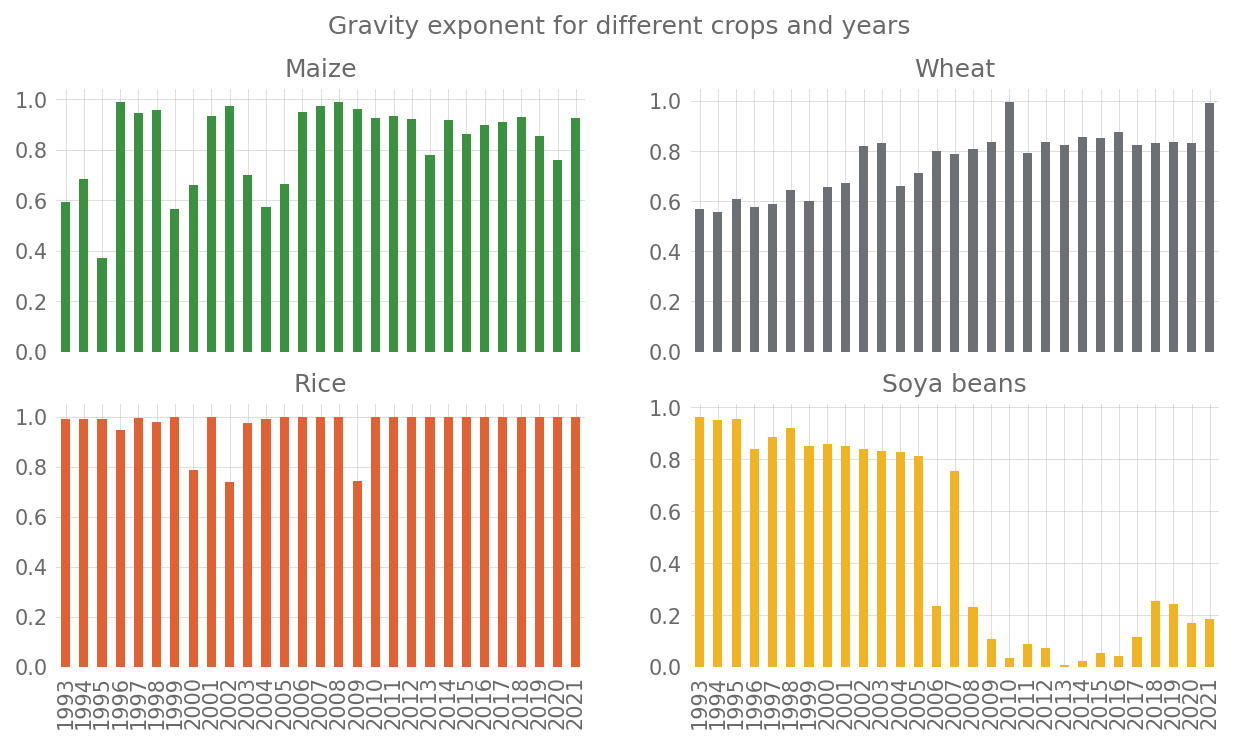

In [17]:
df.plot(kind="bar", title="Gravity exponent for different crops and years", subplots=True, layout=(2, 2), figsize=(10, 5), legend=False)